In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os
from keras import backend as K
from keras.layers import Conv2D, Dropout, LSTM, BatchNormalization, Input,Activation, MaxPool2D, Flatten, Dense,TimeDistributed
from keras.models import Model, load_model
from keras import metrics 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
VIDEOS_DIR = './Videos/'
IMAGES_DIR = './Images/'

In [16]:
classes = list(os.listdir(VIDEOS_DIR))
print(classes)

['Kicking', 'Riding-Horse', 'Running', 'SkateBoarding', 'Swing-Bench', 'Lifting', 'Swing-Side', 'Walking', 'Golf-Swing']


In [17]:
class_to_index = {}
for i in range(len(classes)):
    class_to_index[classes[i]] = i
class_to_index

{'Golf-Swing': 8,
 'Kicking': 0,
 'Lifting': 5,
 'Riding-Horse': 1,
 'Running': 2,
 'SkateBoarding': 3,
 'Swing-Bench': 4,
 'Swing-Side': 6,
 'Walking': 7}

In [18]:
videos = []
for x in classes:
    videos.append(list(os.listdir(VIDEOS_DIR+x+'/')))
print(videos)

[['006', '017', '003', '016', '009', '013', '005', '012', '010', '015', '014', '007', '004', '011', '002', '001'], ['006', '003', '009', '005', '010', '007', '004', '002', '008', '001'], ['006', '009', '005', '010', '007', '004', '002', '008', '001'], ['006', '003', '009', '005', '010', '007', '004', '002', '008', '001'], ['006', '017', '003', '016', '009', '013', '005', '012', '010', '015', '014', '007', '004', '011', '002', '008', '001'], ['003', '005', '004', '002', '001'], ['006', '003', '009', '005', '010', '007', '004', '011', '002', '008', '001'], ['006', '017', '003', '016', '009', '013', '005', '012', '010', '015', '014', '007', '019', '004', '011', '018', '002', '008', '001'], ['006', '003', '009', '013', '005', '012', '010', '014', '007', '004', '011', '002', '008', '001']]


In [12]:
# Using default 10 images per second
def convert_videos_to_images(video_path, image_path):
    print(video_path)
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    count = 0
    
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret == True:
            count += 1
            name = "{0:0=3d}".format(count)
            cv2.imwrite(image_path+name+'.png', frame) 
        else: 
            break

    # When everything done, release the video capture object
    cap.release()

    print(count)

In [51]:
for i in range(len(classes)):
    cls = classes[i]
    for j in range(len(videos[i])):
        vid = videos[i][j]
        video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
        image_r = IMAGES_DIR+cls+'/'+ vid +'/'
        filelist= list(os.listdir(video_r))
        for fichier in filelist:
            if not(fichier.endswith(".avi")):
                filelist.remove(fichier)
        assert(len(filelist) == 1)
        convert_videos_to_images(video_r+filelist[0], image_r)

./Videos/Kicking/006/5117-8_70113.avi
23
./Videos/Kicking/017/RF1-16941_70021.avi
23
./Videos/Kicking/003/3833-27_70006.avi
23
./Videos/Kicking/016/6351-1_70011.avi
23
./Videos/Kicking/009/6731-2_70017.avi
22
./Videos/Kicking/013/5117-8_70350.avi
23
./Videos/Kicking/005/3949-12_70207.avi
23
./Videos/Kicking/012/3833-41_70187.avi
23
./Videos/Kicking/010/3833-15_70577.avi
23
./Videos/Kicking/015/6063-20_70333.avi
23
./Videos/Kicking/014/5863-29_70025.avi
23
./Videos/Kicking/007/6063-21_70056.avi


KeyboardInterrupt: 

In [156]:
for i in range(len(classes)):
    cls = classes[i]
    for j in range(len(videos[i])):
        vid = videos[i][j]
        video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
        image_r = IMAGES_DIR+cls+'/'+ vid +'/'
        filelist = list(os.listdir(image_r))
        if len(filelist) <= 10:
            print(image_r)

./Images/Swing-Side/003/
./Images/Swing-Side/005/


In [19]:
def permute(X,Y):
    train_size = X.shape[0]
    permutation_train = np.random.permutation(train_size)
    X = X[permutation_train]
    Y = Y[permutation_train]
    return X,Y

In [20]:
def load_image(path,image_size):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    return image

In [15]:
def build_dataset(image_size):
    X_train_images = []
    Y_train_images = []
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = list(os.listdir(image_r))
            #print(sorted(filelist))
            X_train_images_video = []
            for fichier in filelist:
                if fichier.endswith(".png"):
                    image = load_image(image_r+fichier,image_size)
                    X_train_images_video.append(image)
            permutation = np.random.permutation(len(X_train_images_video))
            X_train_images_video = np.array(X_train_images_video)[permutation]
            X_train_images += list(X_train_images_video[:10])
            Y_train_images += [i]*10
    return permute(np.array(X_train_images), np.array(Y_train_images))

In [16]:
X_train, Y_train = build_dataset((172, 172))

In [17]:
X_train.shape

(1097, 172, 172, 3)

In [18]:
Y_train.shape

(1097,)

In [21]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

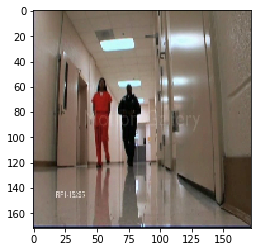

In [20]:
plt.imshow(X_train[98])

In [21]:
X_train.dtype

dtype('uint8')

In [37]:
def build_model(input_shape):
    X_input = Input(input_shape, name = "Input")
    
    X = BatchNormalization(name = 'BatchNorm_1')(X_input)
    X = Conv2D(32, (7, 7), strides = (5, 5), name="Conv_1a", padding="same")(X)
    X = Activation('relu')(X)
    
    X = Conv2D(32, (3, 3), name = "Conv_1b", padding="same")(X)
    X = Activation('relu')(X)
    X = MaxPool2D((2, 2), name = "Pool_1")(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(32, (3, 3), name ="Conv_2", padding = "same")(X)
    X = Activation('relu')(X)
    X = MaxPool2D((4, 4), name = "Pool_2")(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(8,(1,1), name='Conv_1x1')(X)
    
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    
    return Model(X_input, X)

In [38]:
model = build_model((172, 172, 3))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 35, 35, 32)        4736      
_________________________________________________________________
activation_1 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Conv_1b (Conv2D)             (None, 35, 35, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 17, 17, 32)        0         
__________

In [40]:
def CNN_model(prev_model):
    X = Dense(9,activation='softmax',name='final')(prev_model.output)
    return Model(prev_model.input, X)

In [41]:
cnn = CNN_model(model)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 172, 172, 3)       0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 172, 172, 3)       12        
_________________________________________________________________
Conv_1a (Conv2D)             (None, 35, 35, 32)        4736      
_________________________________________________________________
activation_1 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Conv_1b (Conv2D)             (None, 35, 35, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 17, 17, 32)        0         
__________

In [42]:
cnn.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [27]:
Y_train_one = convert_to_one_hot(Y_train, 9) 

In [35]:
cnn.fit(X_train, 
        Y_train_one, 
        batch_size=128, 
        epochs=3,
        validation_split=0.1)

Train on 987 samples, validate on 110 samples
Epoch 1/3
987/987 [==============================] - 8s 8ms/step - loss: 0.4851 - acc: 0.8440 - val_loss: 0.4728 - val_acc: 0.9091
Epoch 2/3
987/987 [==============================] - 10s 11ms/step - loss: 0.4871 - acc: 0.8389 - val_loss: 0.3746 - val_acc: 0.9182
Epoch 3/3
987/987 [==============================] - 10s 10ms/step - loss: 0.4700 - acc: 0.8338 - val_loss: 0.3259 - val_acc: 0.9455


In [36]:
cnn.save('model_conv_17epochs_valacc_94.h5')

### Test with LSTm

In [83]:
def rnn_model(input_shape):
    X_input = Input(input_shape)
    X = LSTM(32, return_sequences=True)(X_input)
    X = LSTM(32, return_sequences=False)(X)
    X = Dense(9,activation='softmax')(X)
    return Model(X_input, X)

In [84]:
rnn = rnn_model((40,128))

In [85]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 40, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 40, 32)            20608     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 297       
Total params: 29,225
Trainable params: 29,225
Non-trainable params: 0
_________________________________________________________________


In [25]:
def model_predict(model,images):
    output = K.function([model.layers[0].input,K.learning_phase()],
                        [model.layers[13].output])
    return output([images,0])[0]

In [26]:
def pad(X_cnn,max_len):
    features_len = X_cnn.shape[1]
    length = X_cnn.shape[0]
    X_cnn = list(X_cnn)
    pad_arr = [0 for i in range(features_len)]
    for i in range(max_len-length):
        X_cnn.append(pad_arr)
    return np.array(X_cnn)    

In [51]:
def build_dataset_for_lstm(image_size, pad_len = 150):
    
    model = load_model('model_conv_17epochs_valacc_94.h5')
    
    X_train_images = []
    Y_train_images = []
    
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            
            X_cnn = model_predict(model,np.array(X_train_images_class))
            X_cnn = pad(X_cnn,pad_len) # Pad till 170 frames
            X_train_images.append(X_cnn)
            assert(X_train_images[0].shape == (150,128))
            Y_train_images.append(i)    
            
            print("Processed",videos[i][j],"of","class",classes[i])
    return X_train_images,Y_train_images       

In [22]:
for i in range(0,38,10):
    lower = i
    upper = min(38,i+40)
    print(lower,upper)
    if upper == 38:
        break
    

0 38


In [31]:
def build_dataset_for_lstm_strided(image_size, stride = 10, max_len = 40):
    
    model = load_model('models/Conv/17epochs_valacc_94.h5')
    
    X_train_images = []
    Y_train_images = []
    
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            X_cnn = model_predict(model,np.array(X_train_images_class))
            print(X_cnn.shape)
            
            for k in range(0,X_cnn.shape[0],stride):
                lower = k
                upper = min(X_cnn.shape[0],k+max_len)
                if upper == X_cnn.shape[0]:
                    X_train_images.append(pad(X_cnn[lower:upper],max_len))
                    Y_train_images.append(i)
                    print("Padded frames" , lower , "to" , upper)
                    break
                else:
                    X_train_images.append(X_cnn[lower:upper])
                    Y_train_images.append(i)
                    print("Added frames" , lower , "to" , upper)

           
            print("Processed",videos[i][j],"of","class",classes[i])
    return X_train_images,Y_train_images

In [32]:
X,Y = build_dataset_for_lstm_strided((172,172))

(23, 128)
Padded frames 0 to 23
Processed 006 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 017 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 003 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 016 of class Kicking
(22, 128)
Padded frames 0 to 22
Processed 009 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 013 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 005 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 012 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 010 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 015 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 014 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 007 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 004 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 011 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 002 of class Kicking
(23, 128)
Padded frames 0 to 23
Processed 001 of class 

(75, 128)
Added frames 0 to 40
Added frames 10 to 50
Added frames 20 to 60
Added frames 30 to 70
Padded frames 40 to 75
Processed 011 of class Swing-Side
(75, 128)
Added frames 0 to 40
Added frames 10 to 50
Added frames 20 to 60
Added frames 30 to 70
Padded frames 40 to 75
Processed 002 of class Swing-Side
(14, 128)
Padded frames 0 to 14
Processed 008 of class Swing-Side
(35, 128)
Padded frames 0 to 35
Processed 001 of class Swing-Side
(102, 128)
Added frames 0 to 40
Added frames 10 to 50
Added frames 20 to 60
Added frames 30 to 70
Added frames 40 to 80
Added frames 50 to 90
Added frames 60 to 100
Padded frames 70 to 102
Processed 006 of class Walking
(71, 128)
Added frames 0 to 40
Added frames 10 to 50
Added frames 20 to 60
Added frames 30 to 70
Padded frames 40 to 71
Processed 017 of class Walking
(101, 128)
Added frames 0 to 40
Added frames 10 to 50
Added frames 20 to 60
Added frames 30 to 70
Added frames 40 to 80
Added frames 50 to 90
Added frames 60 to 100
Padded frames 70 to 101


In [33]:
X = np.array(X)
Y = convert_to_one_hot(np.array(Y),9)
print("Shape X",X.shape)
print("Shape Y",Y.shape)

Shape X (419, 40, 128)
Shape Y (419, 9)


In [34]:
np.save('Numpy/LSTM_Strided/train_X', X)
np.save('Numpy/LSTM_Strided/train_Y', Y)

In [35]:
X[2].shape

(40, 128)

In [93]:
#X,Y = build_dataset_for_lstm((172,172))

Processed 006 of class Kicking
Processed 017 of class Kicking
Processed 003 of class Kicking
Processed 016 of class Kicking
Processed 009 of class Kicking
Processed 013 of class Kicking
Processed 005 of class Kicking
Processed 012 of class Kicking
Processed 010 of class Kicking
Processed 015 of class Kicking
Processed 014 of class Kicking
Processed 007 of class Kicking
Processed 004 of class Kicking
Processed 011 of class Kicking
Processed 002 of class Kicking
Processed 001 of class Kicking
Processed 006 of class Riding-Horse
Processed 003 of class Riding-Horse
Processed 009 of class Riding-Horse
Processed 005 of class Riding-Horse
Processed 010 of class Riding-Horse
Processed 007 of class Riding-Horse
Processed 004 of class Riding-Horse
Processed 002 of class Riding-Horse
Processed 008 of class Riding-Horse
Processed 001 of class Riding-Horse
Processed 006 of class Running
Processed 009 of class Running
Processed 005 of class Running
Processed 010 of class Running
Processed 007 of cla

## RNN Model Start

In [79]:
rnn.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [80]:
X = np.load('Numpy/LSTM_Strided/train_X.npy')
Y = np.load('Numpy/LSTM_Strided/train_Y.npy')
X_train_rnn,Y_train_rnn = permute(X,Y)
#X_train_rnn,X_test_rnn,Y_train_rnn,Y_test_rnn = test_train_split(X,Y)

In [82]:
rnn.fit(X_train_rnn, Y_train_rnn, epochs=500, batch_size = X_train_rnn.shape[0], validation_split=0.2)

Train on 335 samples, validate on 84 samples
Epoch 1/500
335/335 [==============================] - 0s 360us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.2264 - val_acc: 0.9167
Epoch 2/500
335/335 [==============================] - 0s 347us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.2265 - val_acc: 0.9167
Epoch 3/500
335/335 [==============================] - 0s 319us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.2267 - val_acc: 0.9167
Epoch 4/500
335/335 [==============================] - 0s 307us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.2268 - val_acc: 0.9167
Epoch 5/500
335/335 [==============================] - 0s 347us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.2267 - val_acc: 0.9167
Epoch 6/500
335/335 [==============================] - 0s 329us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.2266 - val_acc: 0.9167
Epoch 7/500
335/335 [==============================] - 0s 331us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.2266 - val_acc: 0.9167
Epoch 8/50

Epoch 61/500
335/335 [==============================] - 0s 221us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.2359 - val_acc: 0.9167
Epoch 62/500
335/335 [==============================] - 0s 177us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.2359 - val_acc: 0.9167
Epoch 63/500
335/335 [==============================] - 0s 194us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.2359 - val_acc: 0.9167
Epoch 64/500
335/335 [==============================] - 0s 183us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.2359 - val_acc: 0.9167
Epoch 65/500
335/335 [==============================] - 0s 197us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.2359 - val_acc: 0.9167
Epoch 66/500
335/335 [==============================] - 0s 190us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.2358 - val_acc: 0.9167
Epoch 67/500
335/335 [==============================] - 0s 200us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.2358 - val_acc: 0.9167
Epoch 68/500
335/335 [==========================

KeyboardInterrupt: 

In [69]:
rnn.save('models/LSTM_Strided/500ep_valacc_97_single_LSTM.h5')

### END TO END

In [16]:
def end_to_end(input_shape):
    X_input = Input(input_shape)
    X = TimeDistributed(BatchNormalization(name = 'BatchNorm_1'))(X_input)
    X = TimeDistributed(Conv2D(32, (7, 7), strides = (2, 2), activation='relu', name="Conv_1a", padding="same"))(X)
    X = TimeDistributed(Conv2D(32, (3, 3), strides = (2, 2), activation='relu', name="Conv_1b", padding="same"))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_1"))(X)
    
    X = TimeDistributed(Conv2D(64, (3, 3), name ="Conv_2a", activation='relu', padding = "same"))(X)
    X = TimeDistributed(Conv2D(64, (3, 3), name ="Conv_2b", activation='relu', padding = "same"))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_2"))(X)
    
    X = TimeDistributed(Conv2D(256,(3,3), name='Conv_3a'))(X)
    X = TimeDistributed(MaxPool2D((4, 4), name = "Pool_3"))(X)

    X = TimeDistributed(Flatten())(X)
    
    X = LSTM(32, return_sequences=True)(X)
    X = LSTM(32, return_sequences=False)(X)
    X = Dense(9, activation='softmax')(X)
    
    return Model(X_input,X)
    

In [17]:
e2e = end_to_end((170, 172, 172, 3))

In [18]:
e2e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170, 172, 172, 3)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 172, 172, 3)  12        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 170, 86, 86, 32)   4736      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 170, 43, 43, 32)   9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 170, 21, 21, 32)   0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 170, 21, 21, 64)   18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 170, 21, 21, 64)   36928     
__________

In [19]:
def pad_end_to_end(X_train_images_class,pad_len):
    length = X_train_images_class.shape[0]
    pad_arr = np.zeros((X_train_images_class.shape[1:4]),dtype=np.uint8)
    X_train_images_class = list(X_train_images_class)
    for i in range(pad_len-length):
        X_train_images_class.append(pad_arr)
    return np.array(X_train_images_class,dtype=np.uint8)

In [20]:
a = np.array([[1],[1]],dtype=np.uint8)
x = pad_end_to_end(a,5)
print(x.dtype)

uint8


In [11]:
def build_dataset_end_to_end(image_size, pad_len = 170):
    X_train_images = []
    Y_train_images = []
    for i in range(len(classes)):
        cls = classes[i]
        for j in range(len(videos[i])):
            vid = videos[i][j]
            video_r = VIDEOS_DIR+cls+'/'+ vid +'/'
            image_r = IMAGES_DIR+cls+'/'+ vid +'/'
            filelist = sorted(list(os.listdir(image_r)))
            X_train_images_class = []
            for file in filelist:
                if file.endswith(".png"):
                    image = load_image(image_r+file,image_size)
                    X_train_images_class.append(image)
            X_train_images_class = pad_end_to_end(np.array(X_train_images_class,dtype=np.uint8),pad_len) # Pad till 170 frames
            assert(X_train_images_class.shape == (170,172, 172, 3))
            X_train_images.append(X_train_images_class)
            Y_train_images.append(i)    
            print("Processed",videos[i][j],"of","class",classes[i])
    return np.array(X_train_images,dtype=np.uint8),np.array(Y_train_images,dtype=np.uint8)

In [13]:
try:
    del X
    del Y
except NameError:
    print("X and Y not found!")
    
try:
    X = np.load('X_e2e.npy')
    Y = np.load('Y_e2e.npy')
except FileNotFoundError:    
    X,Y = build_dataset_end_to_end((172, 172))
    np.save('X_e2e.npy',X)
    np.save('Y_e2e.npy',Y)

X and Y not found!


NameError: name 'pad_end_to_end' is not defined

In [24]:
Y = convert_to_one_hot(Y,9)
print(X.shape)
print(Y.shape)

(111, 170, 172, 172, 3)
(111, 9)


In [25]:
e2e.compile(loss='categorical_crossentropy', 
            metrics=['accuracy'], 
            optimizer='adam')

In [26]:
X_train_e2e,Y_train_e2e = permute(X,Y)

In [ ]:
e2e.fit(X_train_e2e, Y_train_e2e, epochs=1, batch_size = 8, validation_split=0.05)

Train on 105 samples, validate on 6 samples
Epoch 1/5


### ConvMLP

In [ ]:
def ConvMLP(input_shape):
    X_input = Input(input_shape)
    X = TimeDistributed(BatchNormalization(name = 'BatchNorm_1'))(X_input)
    X = TimeDistributed(Conv2D(32, (7, 7), strides = (2, 2), activation='relu', name="Conv_1a", padding="same"))(X)
    X = TimeDistributed(Conv2D(32, (3, 3), strides = (2, 2), activation='relu', name="Conv_1b", padding="same"))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_1"))(X)
    
    X = TimeDistributed(Conv2D(64, (3, 3), name ="Conv_2a", activation='relu', padding = "same"))(X)
    X = TimeDistributed(Conv2D(64, (3, 3), name ="Conv_2b", activation='relu', padding = "same"))(X)
    X = TimeDistributed(MaxPool2D((2, 2), name = "Pool_2"))(X)
    
    X = TimeDistributed(Conv2D(256,(3,3), name='Conv_3a'))(X)
    X = TimeDistributed(MaxPool2D((4, 4), name = "Pool_3"))(X)

    X = TimeDistributed(Flatten())(X)
    
    X = LSTM(32, return_sequences=True)(X)
    X = LSTM(32, return_sequences=False)(X)
    X = Dense(9, activation='softmax')(X)
    
    return Model(X_input,X)